In [13]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# clone the AIMNet2 github repository

!git clone https://github.com/isayevlab/AIMNet2.git '/content/drive/MyDrive/AIMNet2-demo/AIMNet2'

Cloning into '/content/drive/MyDrive/AIMNet2-demo/AIMNet2'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 110 (delta 6), reused 3 (delta 3), pack-reused 93
Receiving objects: 100% (110/110), 66.45 MiB | 10.62 MiB/s, done.
Resolving deltas: 100% (51/51), done.
Updating files: 100% (24/24), done.


In [15]:
# install ase & py3Dmol

!pip install ase
!pip install py3Dmol

In [16]:
%cd drive/MyDrive/AIMNet2-demo/

[Errno 2] No such file or directory: 'drive/MyDrive/AIMNet2-demo/'
/content/drive/MyDrive/AIMNet2-demo


In [17]:
# list all the available AIMNet2 models

os.listdir(os.getcwd() + '/AIMNet2/models/')

['aimnet2_b973c_0.jpt',
 'aimnet2_b973c_1.jpt',
 'aimnet2_b973c_2.jpt',
 'aimnet2_b973c_3.jpt',
 'aimnet2_b973c_ens.jpt',
 'aimnet2_wb97m-d3_0.jpt',
 'aimnet2_wb97m-d3_1.jpt',
 'aimnet2_wb97m-d3_2.jpt',
 'aimnet2_wb97m-d3_3.jpt',
 'aimnet2_wb97m-d3_ens.jpt',
 'ensemble.py']

In [18]:
# import the required python packages

import torch
import ase.io
import py3Dmol
import numpy as np
import pandas as pd
from typing import Dict, List
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [19]:
# load model and store the filepaths of the molecules for analysis

root_dir = os.getcwd() + '/Test_Molecules/'
mol1_path = root_dir + 'ATP_Conformer3D_COMPOUND_CID_5957.xyz'
mol2_path = root_dir + 'ADP_Conformer3D_COMPOUND_CID_7058055.xyz'
mol3_path = root_dir + 'ACUBOT.xyz'
mol4_path = root_dir + 'ACOHAF.xyz'
mol5_path = root_dir + 'ACUBEJ.xyz'

model = torch.jit.load('./AIMNet2/models/aimnet2_b973c_1.jpt')

In [20]:
# function to convert molecular information to AIMNet2 style dictionary input

def mol_to_dict(data) -> Dict[str, torch.Tensor]:
  positions = torch.tensor(data.get_positions(), requires_grad=False)
  atomic_numbers = torch.tensor(data.get_atomic_numbers(), requires_grad=False)
  total_charge = torch.tensor([0.0], requires_grad=False).expand(1)
  atomic_symbols = [data.get_chemical_symbols()[i] for i in range(len(data))]

  dct = {
        'coord': positions.view(1, -1, 3),  # Reshape to (1, m*n, 3) where m is 1 for a single sample
        'numbers': atomic_numbers.view(1, -1),  # Reshape to (1, m*n) where m is 1 for a single sample
        'charge': total_charge  # Shape is already (m, ) where m is 1 for a single sample
        }
  return dct, atomic_symbols

# function for model inference

def model_inference(mol_path, element_map):
  mol = ase.io.read(mol_path)
  data, atom_symbs = mol_to_dict(mol)
  with torch.no_grad():
    output = model(data)
  aim_shape = output['aim'].shape
  aim_embedding = output['aim'].reshape(aim_shape[1], aim_shape[2])
  energy = output['energy'].detach().numpy().flatten() * 23.0609
  atom_chgs = output['charges'].detach().numpy().flatten()
  df = pd.DataFrame({'Atom': atom_symbs, 'Partial Atomic Charge': atom_chgs})
  df['Atom Type'] = df['Atom'].map(element_map)
  return energy.item(), aim_embedding, df

# function to visualize molecules

def visualize_mol(mol_path):
  mol_xyz = open(mol_path).read()
  view = py3Dmol.view(width=400, height=300)
  view.addModel(mol_xyz, format='xyz')
  view.setStyle({'stick': {}})
  view.setBackgroundColor('white')
  view.zoomTo()
  view.show()

# function to plot t-SNE from AIM embeddings

def plot_tsne(df, mol_aim, element_map):
  tsne = TSNE(n_components=2, random_state=42)
  res = tsne.fit_transform(mol_aim)
  colors = [element_map[element] for element in element_map.keys()]
  cmap = ListedColormap(plt.cm.plasma(np.linspace(0, 1, len(colors))))

  fig, axes = plt.subplots(1, 2, figsize=(16, 4))

  sc1 = axes[0].scatter(res[:, 0], res[:, 1], c=df['Atom Type'], cmap=cmap, label='Atom Type')
  cbar1 = plt.colorbar(sc1, ax=axes[0], ticks=range(len(element_map)), label='Atom Type')
  cbar1.set_ticklabels(element_map.keys())
  axes[0].set_xlabel('t-SNE 1')
  axes[0].set_ylabel('t-SNE 2')

  sc2 = axes[1].scatter(res[:, 0], res[:, 1], c=df['Partial Atomic Charge'], cmap='coolwarm', label='Partial Atomic Charge')
  cbar2 = plt.colorbar(sc2, ax=axes[1], label='Partial Atomic Charge')
  axes[1].set_xlabel('t-SNE 1')
  axes[1].set_ylabel('t-SNE 2')

  plt.show()

In [21]:
# AIMNet2 element map

element_map = {element: i for i, element in enumerate(['H', 'B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br', 'I'])}

# predict energy and partial atomic charges

energy1, aim1, df1 = model_inference(mol1_path, element_map)
energy2, aim2, df2 = model_inference(mol2_path, element_map)
energy3, aim3, df3 = model_inference(mol3_path, element_map)
energy4, aim4, df4 = model_inference(mol4_path, element_map)
energy5, aim5, df5 = model_inference(mol5_path, element_map)

In [22]:
visualize_mol(mol1_path)
print()
print('Molecule: ', mol1_path, ' Energy: ', energy1, 'kcal/mol')
print()
df1

3Dmol.js failed to load for some reason. Please check your browser console for error messages.


Molecule:  /content/drive/MyDrive/AIMNet2-demo/Test_Molecules/ATP_Conformer3D_COMPOUND_CID_5957.xyz  Energy:  -1672865.1473982332 kcal/mol



,Atom,Partial Atomic Charge,Atom Type
0,P,0.517088,7
1,P,0.554833,7
2,P,0.540232,7
3,O,-0.206976,4
4,O,-0.433297,4
5,O,-0.444279,4
6,O,-0.171511,4
7,O,-0.115526,4
8,O,-0.384994,4
9,O,-0.418463,4


In [23]:
visualize_mol(mol2_path)
print()
print('Molecule: ', mol2_path, ' Energy: ', energy2, 'kcal/mol')
print()
df2

3Dmol.js failed to load for some reason. Please check your browser console for error messages.


Molecule:  /content/drive/MyDrive/AIMNet2-demo/Test_Molecules/ADP_Conformer3D_COMPOUND_CID_7058055.xyz  Energy:  -1315414.6533704456 kcal/mol



,Atom,Partial Atomic Charge,Atom Type
0,P,0.647166,7
1,P,0.752865,7
2,O,-0.229232,4
3,O,-0.420915,4
4,O,-0.439294,4
5,O,-0.172998,4
6,O,-0.079298,4
7,O,-0.371142,4
8,O,-0.362009,4
9,O,-0.324598,4


In [24]:
visualize_mol(mol3_path)
print()
print('Molecule: ', mol3_path, ' Energy: ', energy3, 'kcal/mol')
print()
df3

3Dmol.js failed to load for some reason. Please check your browser console for error messages.


Molecule:  /content/drive/MyDrive/AIMNet2-demo/Test_Molecules/ACUBOT.xyz  Energy:  -4745014.711353423 kcal/mol



,Atom,Partial Atomic Charge,Atom Type
0,P,-0.128733,7
1,H,0.033254,0
2,C,-0.295694,2
3,H,-0.015237,0
4,H,-0.021664,0
...,...,...,...
174,H,0.031798,0
175,H,0.044175,0
176,C,-0.040123,2
177,H,0.090283,0


In [25]:
visualize_mol(mol4_path)
print()
print('Molecule: ', mol4_path, ' Energy: ', energy4, 'kcal/mol')
print()
df4

3Dmol.js failed to load for some reason. Please check your browser console for error messages.


Molecule:  /content/drive/MyDrive/AIMNet2-demo/Test_Molecules/ACOHAF.xyz  Energy:  -537800.8757660157 kcal/mol



,Atom,Partial Atomic Charge,Atom Type
0,F,-0.141699,5
1,O,-0.213964,4
2,O,-0.463472,4
3,C,0.399637,2
4,C,0.000945,2
5,C,-0.130018,2
6,H,0.127116,0
7,C,-0.155140,2
8,H,0.167523,0
9,C,0.125556,2


In [26]:
visualize_mol(mol5_path)
print()
print('Molecule: ', mol5_path, ' Energy: ', energy5, 'kcal/mol')
print()
df5

3Dmol.js failed to load for some reason. Please check your browser console for error messages.


Molecule:  /content/drive/MyDrive/AIMNet2-demo/Test_Molecules/ACUBEJ.xyz  Energy:  -5227776.0311539015 kcal/mol



,Atom,Partial Atomic Charge,Atom Type
0,Br,-0.777281,12
1,B,0.035952,1
2,B,-0.526240,1
3,O,-0.200926,4
4,H,0.244983,0
...,...,...,...
123,H,0.079572,0
124,C,-0.342270,2
125,H,0.043551,0
126,H,0.137878,0


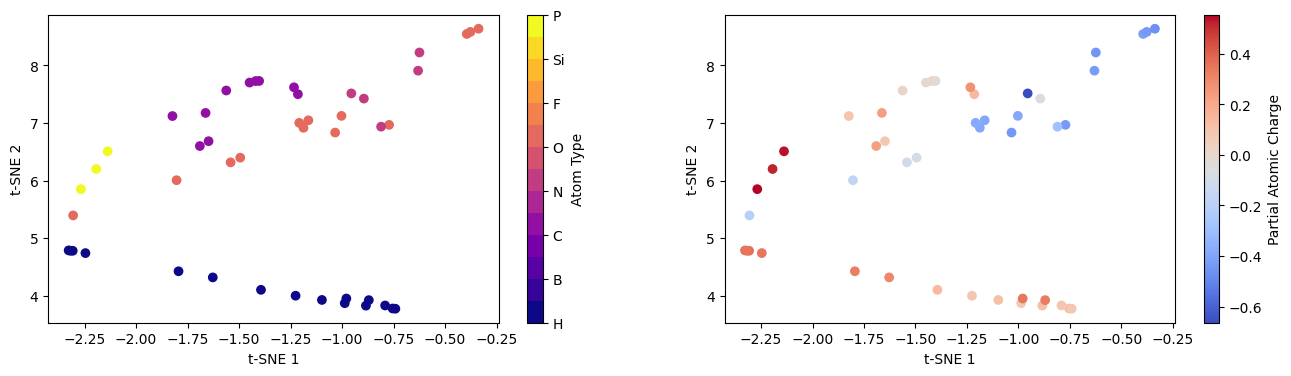

In [27]:
plot_tsne(df1, aim1, element_map)

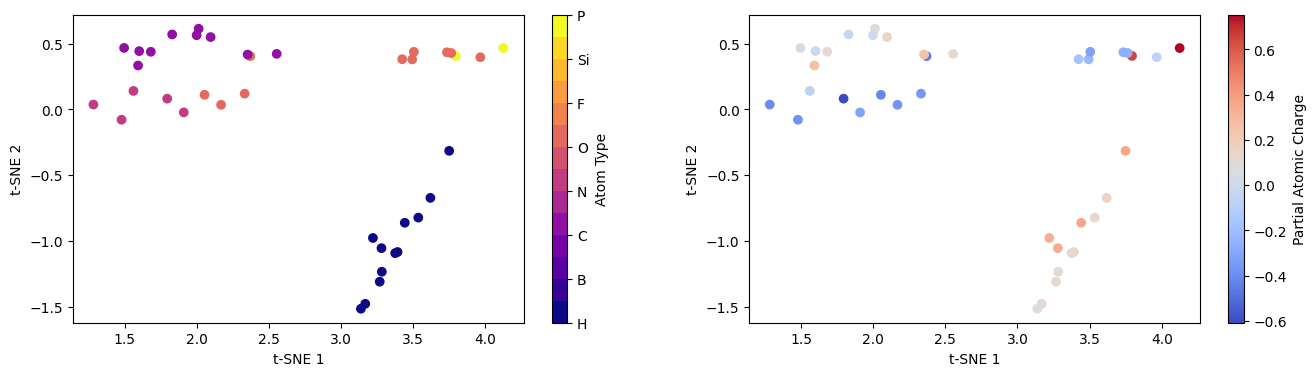

In [28]:
plot_tsne(df2, aim2, element_map)

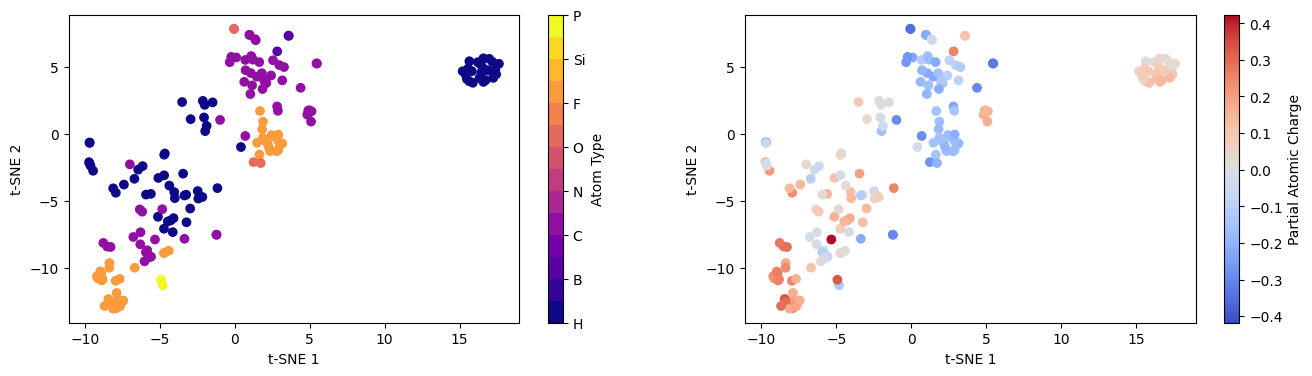

In [29]:
plot_tsne(df3, aim3, element_map)

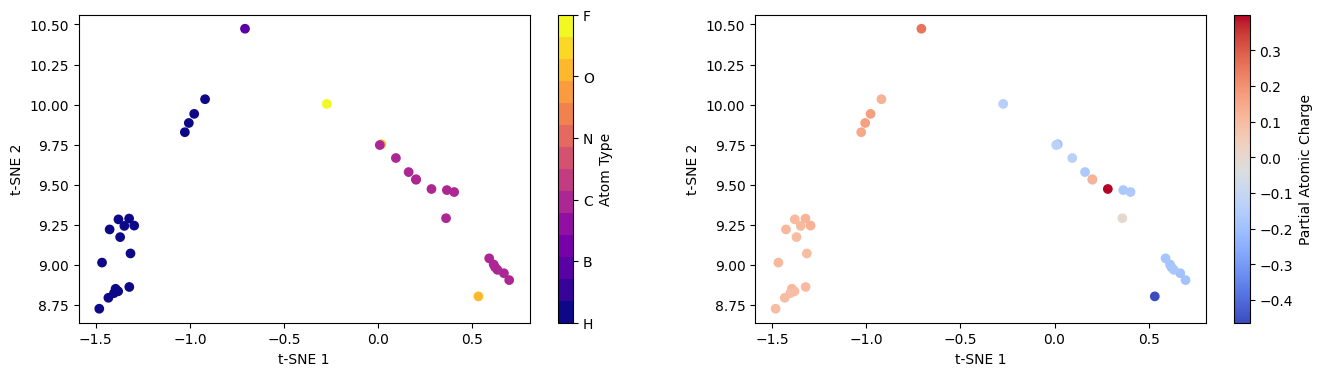

In [30]:
plot_tsne(df4, aim4, element_map)

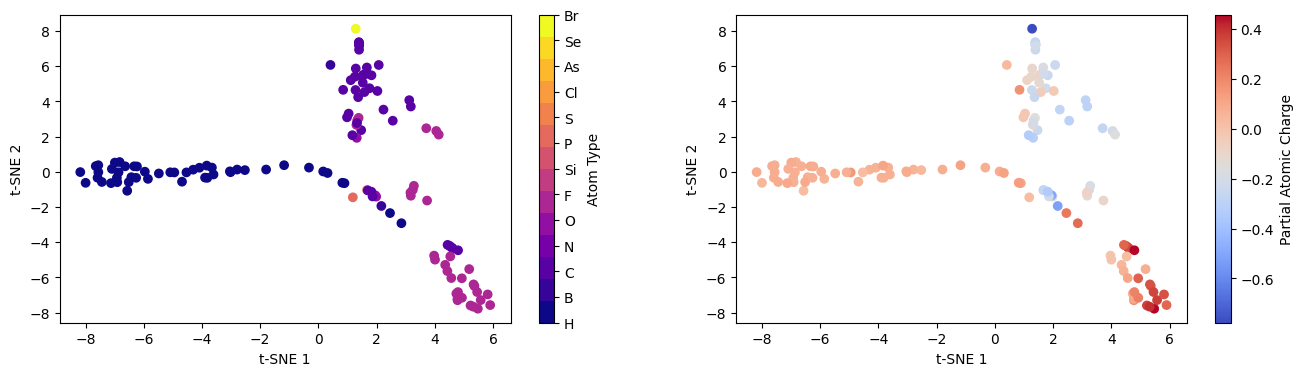

In [31]:
plot_tsne(df5, aim5, element_map)